# The Mathematical Engineering of Deep Learning

## Practical 4 (Julia version)
**For an R or Python version see the [course website](https://deeplearningmath.org/)**.

In [353]:
using RData, DataFrames, Random
Random.seed!(10)
df = load("planar_solar.RData")["planarsolar"]
nrow = size(df)[1]
@show nrow
# df = df[shuffle(1:nrow),:]
head(df)

nrow = 400


,x1,x2,y
,Float64,Float64,Float64
1,1.20444,3.57611,0.0
2,0.15871,-1.48217,0.0
3,0.0952472,-1.27996,0.0
4,0.349178,-2.06438,0.0
5,0.69415,2.88911,0.0
6,1.62065,-4.03512,0.0


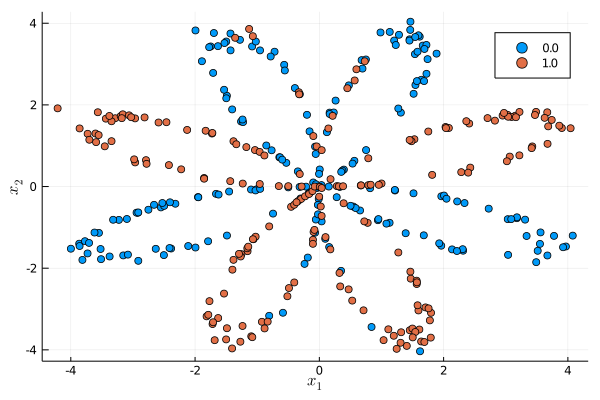

In [354]:
using StatsPlots, LaTeXStrings
@df df scatter(:x1,:x2,group = :y,xlabel=L"x_1",ylabel=L"x_2")

In [355]:
train_test_split_index = Int(nrow*0.8)
train = df[1:train_test_split_index,:]
@show size(train)
head(train)

size(train) = (320, 3)


,x1,x2,y
,Float64,Float64,Float64
1,1.20444,3.57611,0.0
2,0.15871,-1.48217,0.0
3,0.0952472,-1.27996,0.0
4,0.349178,-2.06438,0.0
5,0.69415,2.88911,0.0
6,1.62065,-4.03512,0.0


In [356]:
test = df[(train_test_split_index+1):nrow,:]
@show size(test)
head(test)

size(test) = (80, 3)


,x1,x2,y
,Float64,Float64,Float64
1,-2.12767,1.38667,1.0
2,-2.96425,0.590891,1.0
3,-3.60274,1.299,1.0
4,-1.17473,0.965871,1.0
5,-2.58752,1.56882,1.0
6,-3.16294,1.7693,1.0


In [357]:
x_train = convert(Matrix,train[:,[:x1,:x2]])'
y_train = train.y

x_test = convert(Matrix,test[:,[:x1,:x2]])'
y_test = test.y;

In [358]:
σ(x) = 1/(1+exp(-x))  #Use \sigma + [TAB] for σ

σ (generic function with 1 method)

In [359]:
function getLayerSize(X,y)
    ls = Dict()
    ls[:n_x] = size(X)[1]
    ls[:m] = size(X)[2]
    ls[:n_y] = 1
    return ls
end

getLayerSize (generic function with 1 method)

In [360]:
using Distributions

function initializeParameters(dict_layer_size)
    W1 = rand(Normal(0,1),dict_layer_size[:n_y],dict_layer_size[:n_x])
    b1 = fill(0.0,dict_layer_size[:n_y],1)
    params = Dict()
    params[:W1] = W1
    params[:b1] = b1
    return params
end

initializeParameters (generic function with 1 method)

In [361]:
function forwardPropagation(X,params,list_layer_size)
    Z1 = params[:W1]*X .+ params[:b1]
    A1 = σ.(Z1)
    cache = Dict()
    cache[:Z1] = Z1
    cache[:A1] = A1
    return cache
end

forwardPropagation (generic function with 1 method)

In [362]:
using Statistics
ϵ = 1e-8
computeCost(y,cache) = -mean(log.(cache[:A1].+ ϵ) .* y  + log.(1 .- cache[:A1] .+ ϵ).*(1 .- y))

computeCost (generic function with 1 method)

In [363]:
function backwardPropagation(X,y,cache,params,list_layer_size)
    dZ1 = cache[:A1] - y'
    dW1 = (1/list_layer_size[:m])*dZ1*X'
    db1 = (1/list_layer_size[:m])*sum(dZ1)
    grads = Dict()
    grads[:dW1] = dW1
    grads[:db1] = db1
    return grads
end

backwardPropagation (generic function with 1 method)

In [364]:
function updateParameters(grads,params,η) # \eta + [TAB]
    W1 = params[:W1] .- η*grads[:dW1]
    b1 = params[:b1] .- η*grads[:db1]
    newParams = Dict()
    newParams[:W1] = W1
    newParams[:b1] = b1
    return newParams
end

updateParameters (generic function with 1 method)

In [312]:
##### This is here to debug
# ls = getLayerSize(x_train,y_train)
# pr = initializeParameters(ls)
# ch = forwardPropagation(x_train,pr,ls)
# cst = computeCost(y_train,ch)
# @show cst
# gr = backwardPropagation(x_train,y_train,ch,pr,ls)
# updateParameters(gr,pr,0.001)

In [365]:
function trainModel(X,y,num_iterations,η)
    ls = getLayerSize(X,y)
    pr = initializeParameters(ls)
    costHistory = []
    
    for i in 1:num_iterations
        ch = forwardPropagation(X,pr,ls)
        cost = computeCost(y,ch)
        push!(costHistory,cost)
        gr = backwardPropagation(X,y,ch,pr,ls)
        pr = updateParameters(gr,pr,η)
        i % 10 == 0 && print(".")
    end
    
    modelOut = Dict()
    modelOut[:params] = pr
    modelOut[:costHist] = costHistory
    return modelOut
end

trainModel (generic function with 1 method)

In [369]:
model1 = trainModel(x_train,y_train,1000,0.01)

....................................................................................................

Dict{Any,Any} with 2 entries:
  :params   => Dict{Any,Any}(:W1=>[0.14036 -0.203539],:b1=>[-0.443863])
  :costHist => Any[0.879176, 0.876257, 0.873364, 0.870497, 0.867657, 0.864843, …

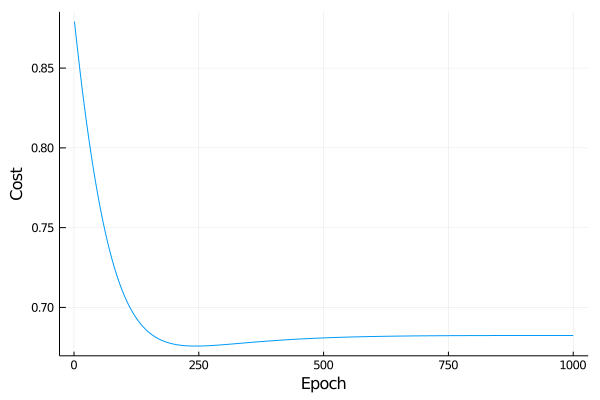

In [370]:
using Plots
plot(model1[:costHist],xlabel="Epoch",ylabel="Cost",legend=false)

In [371]:
using GLM
model2 = glm(@formula(y ~ x1 + x2), train, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x1 + x2

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.491795   0.118085   -4.16    <1e-4   -0.723237  -0.260353
x1            0.142829   0.0617312   2.31    0.0207   0.021838   0.26382
x2           -0.203348   0.0657304  -3.09    0.0020  -0.332177  -0.0745189
──────────────────────────────────────────────────────────────────────────

In [372]:
println("Model 1: ",(model1[:params][:b1],model1[:params][:W1]))
println("Model 2: ", coef(model2))

Model 1: ([-0.4438626593381834], [0.14035969021310446 -0.2035387142119553])
Model 2: [-0.491794750479451, 0.1428289860026892, -0.2033481835966192]


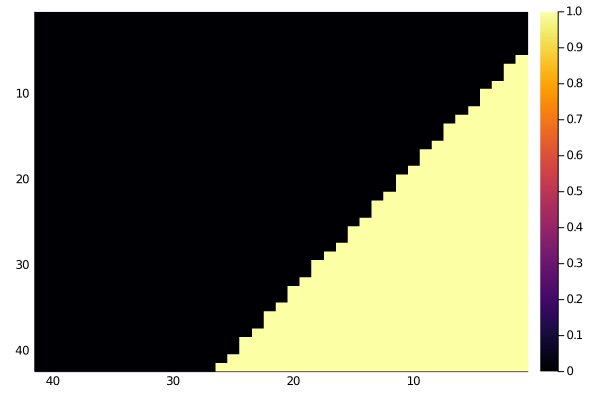

In [373]:
ls = getLayerSize(x_train,y_train)

gridX1 = (minimum(df.x1)-1):0.25:(maximum(df.x1)+1)
gridX2 = (minimum(df.x2)-1):0.25:(maximum(df.x2)+1)
grid = [[x1,x2]  for x1 in gridX1, x2 in gridX2]
rule = [forwardPropagation(x,model1[:params],ls)[:A1][1] .> 0.5 for x in grid]
heatmap(rule,flip=true)

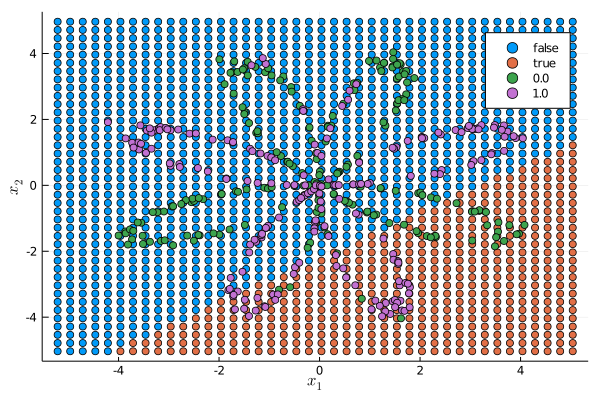

In [374]:
scatter(first.(vec(grid)),last.(vec(grid)),group = vec(rule))#,ms=3,c=[:red :black])
@df df scatter!(:x1,:x2,group = :y,xlabel=L"x_1",ylabel=L"x_2")

# Adding one hidden layer

In [352]:
function feedforward(x,w1,w2)
    z1 = [1 x] * w1
    a1 = σ.(z1)
    z2 = [1 a1] * w2
    Dict(:output => σ.(z2), :a1 => a1)
end

feedforward (generic function with 1 method)

In [350]:
# backpropagate <- function(x, y, y_hat, w1, w2, h, learn_rate) {
#   dw2 <- t(cbind(1, h)) %*% (y_hat - y)
#   dh  <- (y_hat - y) %*% t(w2[-1, , drop = FALSE])
#   dw1 <- t(cbind(1, x)) %*% (h * (1 - h) * dh)
  
#   w1 <- w1 - learn_rate * dw1
#   w2 <- w2 - learn_rate * dw2
  
#   list(w1 = w1, w2 = w2)
# }


Dict{Int64,Int64} with 2 entries:
  3 => 4
  1 => 2

In [ ]:
function backpropagate(x,y,y_hat,w1,w2,a1,η)
    dw2 = [1 a1]' * (yhat-y)
    dh = (y_hat-y) * ()????
    dw = [1 x]' * (a1*(1-a1)*da1)
    
    w1 = w1 - η*dw1
    w2 = w2 - η*dw2
    Dict(:w1 = w1, :w2 = w2)
end

In [ ]:
function train(x,y; hidden = 5, η = 1e-2, iterations = 10^4 )

end
    
# train <- function(x, y, hidden = 5, learn_rate = 1e-2, iterations = 1e4) {
#   d <- ncol(x) + 1
#   w1 <- matrix(rnorm(d * hidden), d, hidden)
#   w2 <- as.matrix(rnorm(hidden + 1))
#   for (i in 1:iterations) {
#     ff <- feedforward(x, w1, w2)
#     bp <- backpropagate(x, y,
#                         y_hat = ff$output,
#                         w1, w2,
#                         h = ff$h,
#                         learn_rate = learn_rate)
#     w1 <- bp$w1; w2 <- bp$w2
#   }
#   list(output = ff$output, w1 = w1, w2 = w2)
# }

# Using a framework (Flux.jl)